# SMHS Project – Part A and Pre‐B Preparation

This notebook:
1. Implements **Part A**: characterization and visualization of latent metabolic clusters.
2. Prepares **Part B** by defining preprocessing strategies and identifying predictors of `metabolic_pressure`
   using correlation analysis and Lasso regression.

All code and comments are in **English**, suitable for direct submission.


In [1]:
# ----- 1. Import libraries -----
import pandas as pd              # Data manipulation
import numpy as np               # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns            # Statistical visualization

sns.set(style="whitegrid", context="notebook")  # Global plotting style


In [2]:
# ----- 2. Load data -----
df = pd.read_csv("SMHS_general-1.csv")                 # Main dataset
df_val = pd.read_csv("SMHS_validation_students-1.csv")# External validation dataset

print("Shape of main dataset:", df.shape)
df.head()


Shape of main dataset: (1500, 29)


,id,age,sex,ethnicity,latent_cluster,deprivation_index,smoking_status,alcohol_units_week,physical_activity_minutes,diet_quality_score,...,fasting_glucose,fasting_insulin,triglycerides,hdl,ldl,crp,alt,shift_worker,family_history_diabetes,metabolic_pressure
0,1,56,F,White,3,74.968216,Former,NaN,92.872646,60.614177,...,7.367951,21.589497,2.607227,0.737260,2.704100,28.432087,37.267948,No,0,73.087968
1,2,59,M,White,2,34.912176,Never,NaN,26.103352,72.107270,...,6.717636,16.379792,3.112712,1.654086,3.750358,1.624550,29.042661,No,0,59.541750
2,3,49,M,Black,2,54.207211,Former,NaN,210.401582,49.249182,...,5.052053,17.104307,4.525291,1.031543,3.812500,2.236999,33.364052,No,1,54.864634
3,4,39,F,White,2,27.870993,Never,NaN,214.605575,61.195129,...,6.018634,21.739572,1.322513,1.232799,4.086235,NaN,22.496442,No,0,49.199538
4,5,45,F,Other,3,72.684155,Never,21.249861,135.063492,49.828539,...,5.826059,16.918793,2.312573,1.014607,3.390955,5.999061,51.853812,No,0,70.674299


In [3]:
# ----- 3. Data types and missing values -----
missing_summary = (
    df.isna().sum()
      .to_frame("n_missing")
      .assign(missing_ratio=lambda x: x["n_missing"]/len(df))
      .sort_values("n_missing", ascending=False)
)
missing_summary


,n_missing,missing_ratio
alcohol_units_week,1241,0.827333
steps_per_day,216,0.144000
crp,121,0.080667
sleep_variability_hours,69,0.046000
fasting_insulin,37,0.024667
id,0,0.000000
sleep_duration_hours,0,0.000000
family_history_diabetes,0,0.000000
shift_worker,0,0.000000
alt,0,0.000000


In [4]:
# ----- 4. Separate numeric and categorical variables -----
numeric_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object","bool"]).columns.tolist()

print("Numeric variables:", numeric_cols)
print("Categorical variables:", categorical_cols)


Numeric variables: ['id', 'age', 'latent_cluster', 'deprivation_index', 'alcohol_units_week', 'physical_activity_minutes', 'diet_quality_score', 'depression_score', 'bmi', 'waist_hip_ratio', 'sbp', 'dbp', 'sleep_duration_hours', 'sleep_variability_hours', 'sleep_efficiency', 'steps_per_day', 'fasting_glucose', 'fasting_insulin', 'triglycerides', 'hdl', 'ldl', 'crp', 'alt', 'family_history_diabetes', 'metabolic_pressure']
Categorical variables: ['sex', 'ethnicity', 'smoking_status', 'shift_worker']


In [5]:
# ----- 5. Cluster size distribution -----
df["latent_cluster"].value_counts().sort_index()


latent_cluster
1    511
2    462
3    286
4    241
Name: count, dtype: int64

## Part A1 – Cluster characterization

In [6]:
# Key continuous variables for cluster characterization
key_continuous = [
    "bmi","waist_hip_ratio","fasting_glucose","fasting_insulin",
    "triglycerides","hdl","ldl","sbp","dbp","crp","alt",
    "physical_activity_minutes","steps_per_day","diet_quality_score",
    "sleep_duration_hours","sleep_efficiency","sleep_variability_hours",
    "depression_score","deprivation_index","metabolic_pressure"
]

cluster_summary = (
    df.groupby("latent_cluster")[key_continuous]
      .agg(["mean","std"])
)
cluster_summary


bmi           waist_hip_ratio           fasting_glucose  \
                     mean       std            mean       std            mean   
latent_cluster                                                                  
1               23.009936  1.961121        0.818052  0.032517        4.950040   
2               34.879969  2.907751        0.915536  0.054120        5.985358   
3               34.239508  2.786238        0.962121  0.051410        6.622009   
4               23.084275  1.987960        0.855375  0.035220        7.215542   

                         fasting_insulin            triglycerides            \
                     std            mean        std          mean       std   
latent_cluster                                                                
1               0.329931        6.280432   1.973942      0.820595  0.208701   
2               0.491256       14.623679   5.005093      1.954077  0.625681   
3               0.566803       27.347412  10.838461      2.966288  1.048340   
4               0.571664        4.305663   1.357294      1.032035  0.266111   

                ... sleep_efficiency           sleep_variability_hours  \
                ...             mean       std                    mean   
latent_cluster  ...                                                      
1               ...        93.654150  3.053757                0.417444   
2               ...        89.062817  4.190682                1.013400   
3               ...        85.034712  5.230863                1.504697   
4               ...        90.840181  3.158053                0.827570   

                         depression_score           deprivation_index  \
                     std             mean       std              mean   
latent_cluster                                                          
1               0.158932         3.639019  2.763603         34.895906   
2               0.245527         7.042559  3.876408         50.261543   
3               0.372073         8.529529  4.150443         68.327880   
4               0.263829         6.416853  3.003950         54.688627   

                          metabolic_pressure            
                      std               mean       std  
latent_cluster                                          
1               13.719711          33.746491  5.411067  
2               14.567958          56.169784  7.340407  
3               13.265701          69.546298  9.387830  
4               13.713283          50.781363  6.156742  

[4 rows x 40 columns]

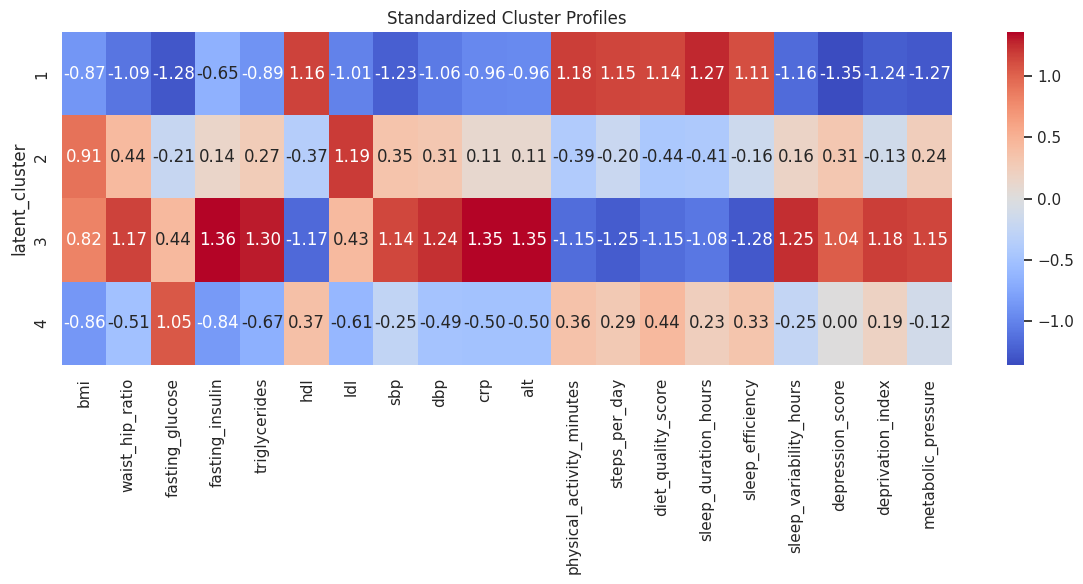

In [7]:
# ----- 6. Heatmap of standardized cluster profiles -----
cluster_means = df.groupby("latent_cluster")[key_continuous].mean()
cluster_means_z = (cluster_means - cluster_means.mean())/cluster_means.std()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means_z, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Standardized Cluster Profiles")
plt.tight_layout()
plt.show()


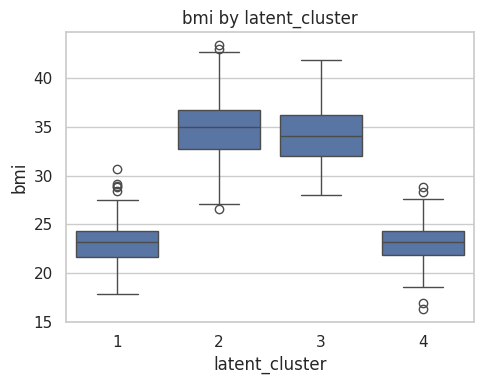

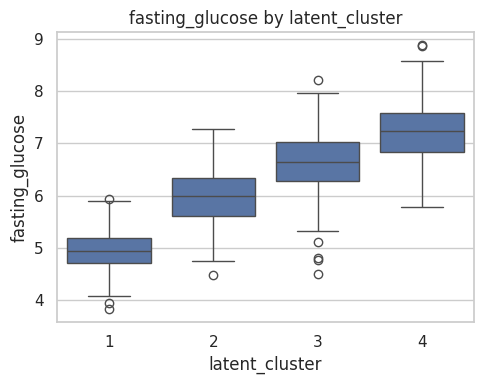

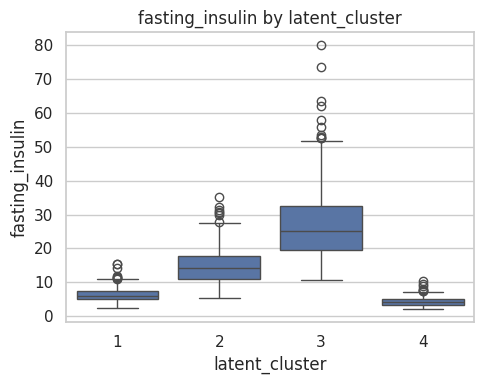

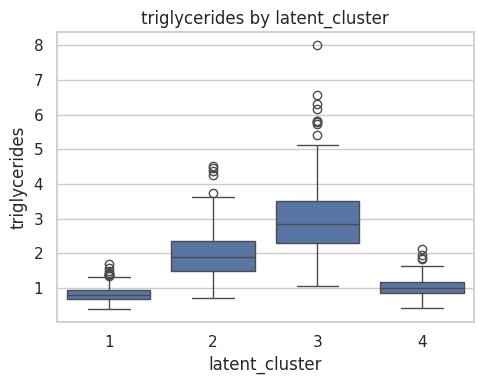

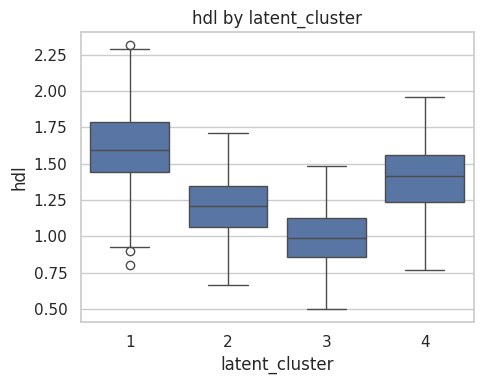

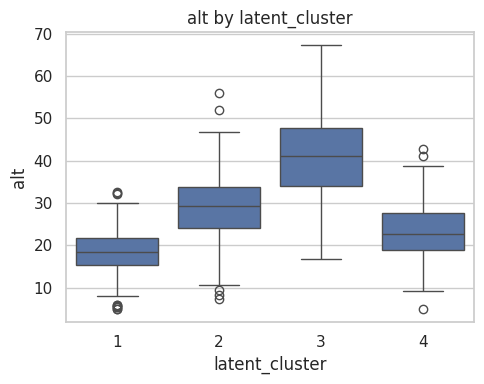

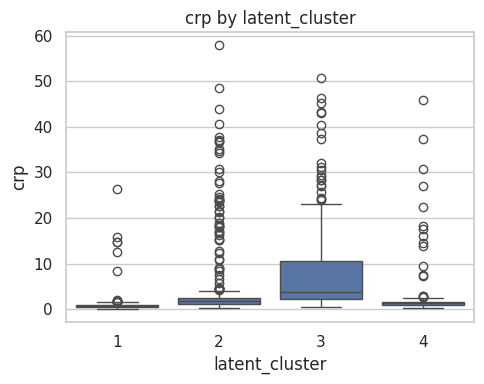

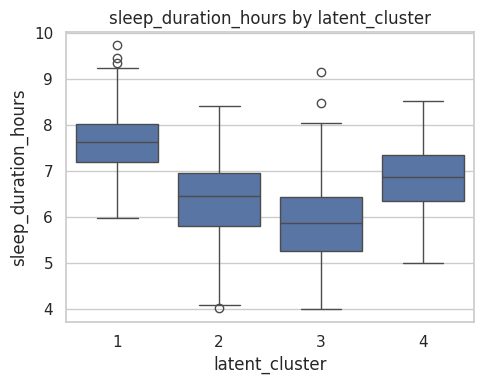

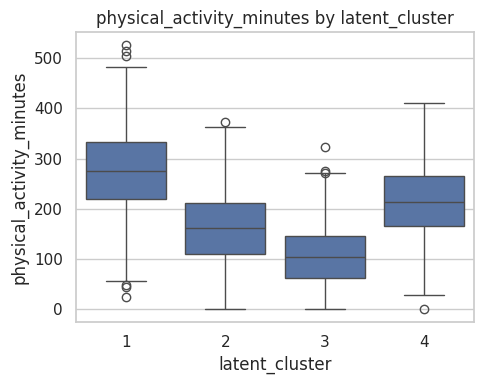

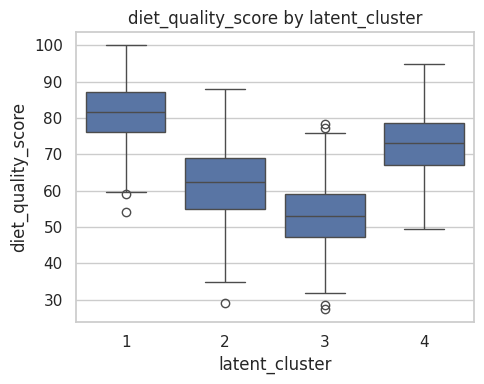

In [8]:
# ----- 7. Boxplots for key distinguishing variables -----
boxplot_vars = [
    "bmi","fasting_glucose","fasting_insulin","triglycerides",
    "hdl","alt","crp","sleep_duration_hours",
    "physical_activity_minutes","diet_quality_score"
]

for v in boxplot_vars:
    plt.figure(figsize=(5,4))
    sns.boxplot(data=df, x="latent_cluster", y=v)
    plt.title(f"{v} by latent_cluster")
    plt.tight_layout()
    plt.show()


## Part B – Preprocessing and feature selection (Pre‐Modeling)

In [9]:
# ----- 8. Prepare data for Part B -----
df_b = df.copy()

# Remove impossible ages
df_b = df_b[(df_b["age"]>=18) & (df_b["age"]<=90)].reset_index(drop=True)

target = "metabolic_pressure"
exclude_cols = ["id","latent_cluster",target]
predictors = [c for c in df_b.columns if c not in exclude_cols]

numeric_features = df_b[predictors].select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = df_b[predictors].select_dtypes(include=["object","bool"]).columns.tolist()


In [10]:
# ----- 9. Correlation analysis with metabolic_pressure -----
corr = df_b[numeric_features + [target]].corr()
corr_target = corr[target].drop(target)

corr_target.sort_values(key=np.abs, ascending=False)


sleep_variability_hours      0.742425
bmi                          0.712813
sleep_duration_hours        -0.692267
fasting_glucose              0.687874
alt                          0.686602
waist_hip_ratio              0.685925
triglycerides                0.681902
fasting_insulin              0.678596
diet_quality_score          -0.675170
hdl                         -0.654358
physical_activity_minutes   -0.572518
deprivation_index            0.569537
sbp                          0.560018
sleep_efficiency            -0.557598
alcohol_units_week           0.547138
steps_per_day               -0.538997
dbp                          0.449455
ldl                          0.439074
depression_score             0.403508
crp                          0.323222
family_history_diabetes      0.199326
age                          0.135440
Name: metabolic_pressure, dtype: float64

In [11]:
# ----- 10. Lasso regression for feature selection -----
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV

X = df_b[predictors]
y = df_b[target]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, numeric_features),
    ("cat", cat_pipe, categorical_features)
])

lasso = LassoCV(cv=5, random_state=42)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", lasso)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)

pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'deprivation_index',
                                                   'alcohol_units_week',
                                                   'physical_activity_minutes',
                                                   'diet_quality_score',
                                                   'depression_score', 'bmi',
                                                   'waist_hip_ratio', 'sbp',
                                                   'dbp',
                                                   'sleep_duration_hours',
                                                   'sleep_variability_ho...
                                                   'sleep_efficiency',
                                                   'steps_per_day',
                                                   'fasting_glucose',
                                                   'fasting_insulin',
                                                   'triglycerides', 'hdl',
                                                   'ldl', 'crp', 'alt',
                                                   'family_history_diabetes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'ethnicity',
                                                   'smoking_status',
                                                   'shift_worker'])])),
                ('model', LassoCV(cv=5, random_state=42))])